#Import necessary libraries:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import Influenza data and format (i.e. break down by year, by week):

Source (for deaths and positivity): https://www.cdc.gov/flu/weekly/

In [ ]:
#training data = (end of)2013-2017/2018
#validation data = 2018/19 and 2019/20

#Mention why data being used is differrent and more recent than what was used in the paper

influ_raw = pd.read_csv('/content/drive/My Drive/ECE 570/Project/NCHSData40.csv')

influDat = dict()

lSet = len(influ_raw) #Total number of rows in the dataset
i = 0
while i < lSet: #For each entry in set
  curYear = influ_raw["Year"][i]
  flu_features = [] #[Weeks, Deaths]

  
  while(influ_raw["Year"][i] == curYear and (i+1) < lSet):
    flu_features.append([influ_raw["Week"][i], influ_raw["All Deaths"][i]])
    i += 1

  influDat[curYear] = flu_features #data
  i += 1


#Import COVID data and format (i.e. break down by week):

Source (for deaths): https://www.cdc.gov/flu/weekly/

In [ ]:
covidDat = []

#Covid Data will be used with 2020 flu season (as that is when it is present)
i = 0

while influ_raw["Year"][i] != 2020:
  i += 1

for j in range(i, lSet):
  covidDat.append([influ_raw["Week"][j], influ_raw["COVID-19 Deaths"][j]])

#Establish fitting and scoring methods:

###We will be using two functions, one for the Influenza data (which contains entries for multiple years) and one for the Covid data (which contains only one year's entry)

- As recommended by the paper, we will be using a forcasting period, and this period was arbitrarily chosen to be 8 weeks.
- One important mentin is that I was unable to implement the recommended kernel in the paper, so I tested other kernels, and saw a good fit in using the ExpSineSquared kernel from scikit-learn.
- Each model is scored on it's coeffiecient of determination.
- Returned from each of these functions is a hash table (dictionary) whose indexing is the given model's score, and the values within each index are:[Model, X_testing_data, y_testing_data].
- It is worth noting that I was experiencing issues in getting the Covid model to have a different score, so I implemented a unique random_state variable that is the sum of each loop control variable.

In [ ]:
def fit_and_forecast_influ(inputArr):
  T = 8 #Max forcasting horizon (in weeks)
  N = len(influDat)

  score_model = {} #Where model scores and models are stored 

  kernel = ExpSineSquared(length_scale=1, periodicity=2)

  for fHorizon in range(T):
    for years in range(N): 
      #assemble a range of T inputs and T outputs for training:
      test_size = T / len(np.array(inputArr[years+2013])[:,1])
      X_train, X_test, y_train, y_test = train_test_split(np.array(inputArr[years+2013])[:,0], np.array(inputArr[years+2013])[:,1], test_size=test_size, random_state=0) #x is week number, y is deaths

      #format data for use
      X_train = X_train.reshape(-1, 1)
      X_test = X_test.reshape(-1, 1)
      y_train = y_train.reshape(-1, 1)
      y_test = y_test.reshape(-1, 1)

      #using this tInput, tOutput, train (preferably a GP)
      model = GaussianProcessRegressor(kernel=kernel).fit(X_train, y_train)
    
      #make forcasts
      score_model[model.score(X_test, y_test)] = [model, X_test, y_test]
  return score_model

def fit_and_forecast_covid(inputArr):
  T = 8 #Max forcasting horizon (in weeks)
  N = 10

  score_model = {} #Where model scores and models are stored 

  kernel = ExpSineSquared(length_scale=1, periodicity=2)

  for fHorizon in range(T):
  #Second loop not really needed as there is only one year in set
    for years in range(N):
      #assemble a range of T inputs and T outputs for training:
      test_size = T / len(np.array(inputArr)[:,1])
      X_train, X_test, y_train, y_test = train_test_split(np.array(inputArr)[:,0], np.array(inputArr)[:,1], test_size=test_size, random_state=0) #x is week number, y is deaths

      #format data for use
      X_train = X_train.reshape(-1, 1)
      X_test = X_test.reshape(-1, 1)
      y_train = y_train.reshape(-1, 1)
      y_test = y_test.reshape(-1, 1)

      #using this tInput, tOutput, train (preferably a GP)
      model = GaussianProcessRegressor(kernel=kernel).fit(X_train, y_train)
    
      #make forcasts
      score_model[model.score(X_test, y_test)] = [model, X_test, y_test]
  
  return score_model

#Use the above model to fit to the influenza data:

The best model score (coefficient of determination) for the Influenza data is 0.871330877938485


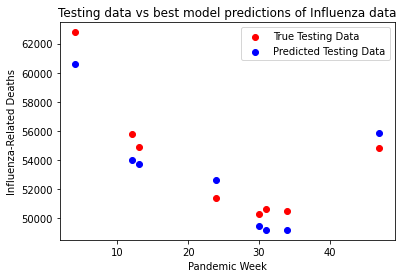

In [ ]:
score_set_influenza = fit_and_forecast_influ(influDat)

#Find and print best scoring model
best_score_influ = max(score_set_influenza)
print(f'The best model score (coefficient of determination) for the Influenza data is {best_score_influ}')

#Get Characteristics of best model
X_test_influ = score_set_influenza[best_score_influ][1]
y_test_influ = score_set_influenza[best_score_influ][2]
best_model_influ = score_set_influenza[best_score_influ][0]

#Plotting
plt.scatter(X_test_influ,  y_test_influ, color="red", label="True Testing Data")
plt.scatter(X_test_influ, best_model_influ.predict(X_test_influ), color="blue", label="Predicted Testing Data")

plt.legend(loc="best")
plt.ylabel("Influenza-Related Deaths")
plt.xlabel("Pandemic Week")
plt.title("Testing data vs best model predictions of Influenza data")

plt.show()

#Similarly, attempt to fit the covid data with it's corresponding model:

The best model score (coefficient of determination) for the Covid data is -0.9170497180859798


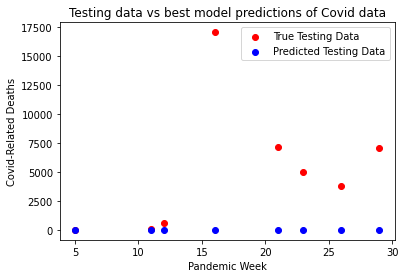

In [ ]:
score_set_covid = fit_and_forecast_covid(covidDat)

#Find and print best scoring model
best_score_covid = max(score_set_covid)
print(f'The best model score (coefficient of determination) for the Covid data is {best_score_covid}')

#Get Characteristics of best model
X_test_covid = score_set_covid[best_score_covid][1]
y_test_covid = score_set_covid[best_score_covid][2]
best_model_covid = score_set_covid[best_score_covid][0]

#Plotting
plt.scatter(X_test_covid,  y_test_covid, color="red", label="True Testing Data")
plt.scatter(X_test_covid, best_model_covid.predict(X_test_covid), color="blue", label="Predicted Testing Data")

plt.legend(loc="best")
plt.ylabel("Covid-Related Deaths")
plt.xlabel("Pandemic Week")
plt.title("Testing data vs best model predictions of Covid data")

plt.show()

#Concatenating the datasets and using the influenza-based model:

The best model score (coefficient of determination) for the Combined data is 0.871330877938485


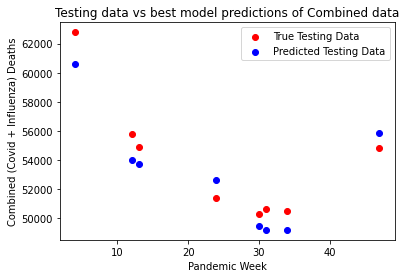

In [ ]:
cat_influ_covid = influDat #concatenated influenza and covid dataset
cat_influ_covid[2021] = covidDat #for the purpose of this example, we will just label the covid data as the year 2021

score_set_comb = fit_and_forecast_influ(influDat)

#Find and print best scoring model
best_score_combo = max(score_set_comb)
print(f'The best model score (coefficient of determination) for the Combined data is {best_score_combo}')

#Get Characteristics of best model
X_test_comb = score_set_comb[best_score_combo][1]
y_test_comb = score_set_comb[best_score_combo][2]
best_model_comb = score_set_comb[best_score_combo][0]

#Plotting
plt.scatter(X_test_comb, y_test_comb, color="red", label="True Testing Data")
plt.scatter(X_test_comb, best_model_comb.predict(X_test_comb), color="blue", label="Predicted Testing Data")

plt.legend(loc="best")
plt.ylabel("Combined (Covid + Influenza) Deaths")
plt.xlabel("Pandemic Week")
plt.title("Testing data vs best model predictions of Combined data")

plt.show()

#Finally, a plot with each model predicting Covid data, using the Covid testing inputs:

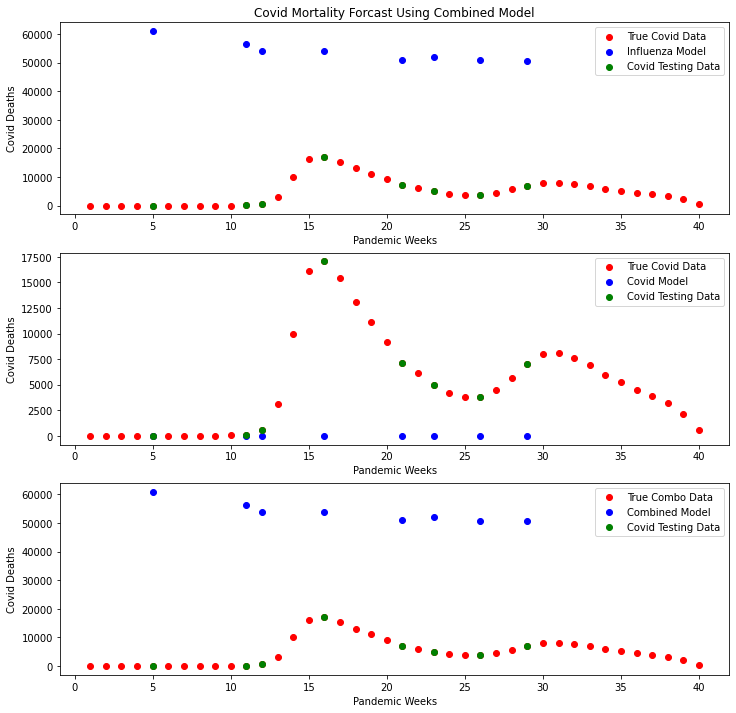

In [ ]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(12,12)

X = np.array(covidDat)[:,0]
y = np.array(covidDat)[:,1]

ax[0].scatter(X, y, color="red", label="True Covid Data")
ax[0].scatter(X_test_covid, best_model_influ.predict(X_test_covid), color="blue", label="Influenza Model")

ax[0].set_title("Covid Mortality Forcast Using Influenza Model")

ax[1].scatter(X, y, color="red", label="True Covid Data")
ax[1].scatter(X_test_covid, best_model_covid.predict(X_test_covid), color="blue", label="Covid Model")

ax[0].set_title("Covid Mortality Forcast Using Covid Model")

ax[2].scatter(X, y, color="red", label="True Combo Data")
ax[2].scatter(X_test_covid, best_model_comb.predict(X_test_covid), color="blue", label="Combined Model")

ax[0].set_title("Covid Mortality Forcast Using Combined Model")

for i in range(3):
  ax[i].scatter(X_test_covid, y_test_covid, color="green", label="Covid Testing Data")
  ax[i].set_xlabel("Pandemic Weeks")
  ax[i].set_ylabel("Covid Deaths")
  ax[i].legend(loc="best")